#Kira Novitchkova-Burbank

# Section 5: Computations and Applications / Final Project

Coming to the end of the term we are going to combine and review topics from the last sections to answer computational questions involving matrices.

## Homework 5: Stationary methods for solving positive definite systems

In class you have discussed iterative methods for solving linear systems. In the following exercise we will implement a stationary method based on a few smoothers (L1 and variations of Gauss-Seidel).

In the code below I have implemented the algorithm for a smoother based stationary method. Stationary solvers are only garaunteed to converge for SPD systems, you might have justified this during lecture.

Your task in this exercise is to create the smoothers and evaluate the convergence rate for each. The smoothers to be implemented are:
*   L1
*   Forward Gauss-Seidel
*   Symmetric Gauss-Seidel

The `stationary` function I have implemented takes `smoother` as an argument. A cool feature of python is syntactically simple first class functions. All that means is functions can be treated just like any other variable. In this case, the `smoother` argument below is a function that takes some `residual` vector and returns the inverse action of the smoother on that vector. As an example, I have implemented Backward Gauss-Seidel.

In [ ]:
from numpy.linalg import norm
from scipy.io import mmread
from scipy.sparse import csr_matrix, tril, triu
from scipy.sparse.linalg import spsolve_triangular
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def stationary(A, rhs, guess, max_iter, epsilon, smoother):
  x = guess.copy()
  residual = rhs - A @ x
  r0_norm = norm(residual)
  norm_history = []

  for iter in range(max_iter):
    r_norm = norm(residual)
    norm_history.append(r_norm)

    if r_norm < epsilon * r0_norm:
      return (True, x, norm_history)

    x += smoother(residual)
    residual = rhs - A @ x

  return (False, x, norm_history)

### Backward Gauss Seidel Solution

In [ ]:
def bgs():
  folder = 'drive/MyDrive/matrices' #'drive/MyDrive/mth343/matrices'
  name = 'bcsstk05'
  mat = mmread(f'{folder}/{name}.mtx').tocsr()
  upper = triu(mat, format='csr')

  def bgs_smoother(residual):
    return spsolve_triangular(upper, residual, lower=False)

  dim = mat.shape[0]
  return stationary(mat, np.ones(dim), np.zeros(dim), 2000, 1e-5, bgs_smoother)

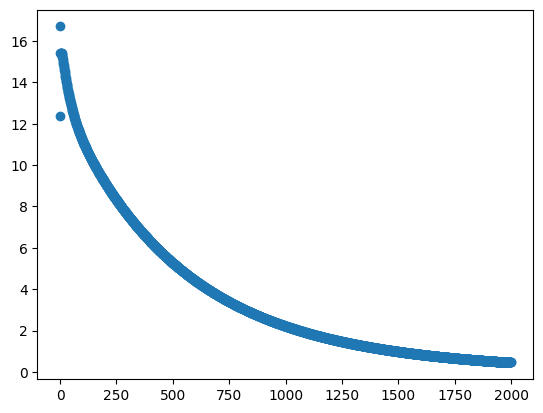

In [ ]:
converged, x, history = bgs()
x = np.arange(len(history))

plt.scatter(x, history)
plt.show()

In [ ]:
# Your code here

## Final Project

There are two algorithms for the final project. You will:
*   implement
*   test with various matrices
*   describe the results by plotting the convergence of the algorithm with respect to the iterations (may provide multiple plots for different sets of parameters)

The basic option is Arnoldi. A bonus part is implementing the Generalized Minimal Residual (GMRES) algorithm on top of it.

### Arnoldi Algorithm

Let $A$ be a given $n \times n$ matrix. We will use it only via its actions on any given vector $\mathbf p$, i.e., it may be given as a function with input $A$ and vector $\mathbf v$ which returns a vector $\mathbf w = A \mathbf v$.


The implementation requires computing inner products of vectors $\mathbf p$ and $\mathbf q$, and norm $\|.\|$ of vectors.
The output of the algorithm is a set of orthogonal vectors $\{\mathbf q_i\}$ and a $m \times m$ matrix $H = (h_{ij})$ where $h_{ij} = 0 $ for $i > j+1$.


- Input: matrix $A$, a vector $\mathbf r$, and an integer $m$. Typical values $m=5, 10, 50, ...$ (much smaller than the size $n$ of the matrix $A$).
- Output: matrix $Q=[\mathbf q_0,\mathbf q_1,\mathbf q_2, \cdots, \mathbf q_m]$ with orthonormal columns and an $m+1 \times m+1$ matrix $H = (h_{ij})$ with zeros below the 1st diagonal below  the main one.
If $A$ is symmetric, $H = (h_{ij})$ is also symmetric and hence becomes tridiagonal, that is, $h_{ij} = 0$ for $|i-j| > 1$ (all entries outside the band of the three main diagonals of the matrix are zero).

#### Algorithm

- Initialize $\mathbf q_0= \mathbf r/\|\mathbf r\|$.
-  Loop: For $j$ in range $(0,m)$:
  - $\mathbf v = A \mathbf q_j$.

  - Loop: For $i$ in range $(0,j+1)$:
    - $h_{ij} = \mathbf q^T_i \mathbf v$
    - $\mathbf v= \mathbf v-h_{ij}\mathbf q_i$
  - $h_{j+1,j} = \|\mathbf v\|$
  - $\mathbf q_{j+1} = \mathbf v/h_{j+1,j}$

#### Analysis
Use `scipy.linalg.eigh_tridiagonal` to get the eigenvalues of the resulting $H$ and plot the maximum and minimum eigenvalues as $H$ grows in size. Calculate the maximum and minimum eigenvalues of the matrix and plot these as horizonal lines on this results.

### Bonus: GMRES

Let $A$ be a given $n \times n$ matrix.
The input for GMRES:

- matrix $A$
- r.h.s. $\mathbf b$
- initial iterate $\mathbf x_0$ (typical values: either zero, or random)
- *max_iter*, the maximal number of iterations allowed (typical values are 100, 1000)
- tolerance $\epsilon$ (typical; values are $10^{-6}$, $10^{-9}$)

The output of the algorithm is $\mathbf x$ the approximate solution, $iter$ - number of iterations used, $\|\mathbf r_0\|, \|\mathbf r\|$ - norm of the initial and  final residuals, and perhaps CPU time.



- Input: GMRES$(A, \mathbf b, \mathbf x_0, m, \mathbf x_0, \epsilon, \text{max_iter})$.

- Output $\mathbf x, \|\mathbf r\|, \|\mathbf r_0\|, \text{iter}, \text{time}$.

#### Algorithm

- Initiate:
  - $\mathbf r_0 = \mathbf b - A \mathbf x_0$, $\delta_0 = \|\mathbf r_0\|$.
  - $\mathbf r = \mathbf r_0$, $\mathbf x=\mathbf x_0$.

  - Loop: For $iter$ from $0$ to max_iter:
    - $P, H = \text{Arnoldi}(A, \mathbf r, m)$
    - $B = AP$.
    - $Q, R= \text{QR}(B)$.
    - $\mathbf z = Q^T\mathbf r$
    - $\mathbf \alpha = \text{upper\_triangual\_solve}(R, \mathbf z)$
    - $\mathbf x+=P\mathbf \alpha$
    - $\mathbf r -= B \mathbf \alpha$.
    - $\delta= \|\mathbf r\|$
    - If $\delta < \epsilon \delta_0$:
      - return $\mathbf x, \|\mathbf r\|, \|\mathbf r_0\|, \text{iter}$ (and CPU time).

#### Analysis
Run on all of the sparse matrices `*.mtx` from the data folder and plot iteration (or run-time) on x-axis and relative residual norm on y-axis.

In [ ]:
import numpy as np
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.linalg import eigh_tridiagonal
from scipy.sparse.linalg import eigsh

#for plots
import matplotlib.pyplot as plt

drive.mount('/content/drive')
# NOTE: change this to the folder in your drive with the data
folder = 'drive/MyDrive/matrices'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


153
153
hello [0.13647334 0.06065482 0.06065482 0.03032741 0.10614593 0.06065482
 0.10614593 0.03032741 0.07581852 0.09098222 0.10614593 0.0151637
 0.04549111 0.06065482 0.         0.10614593 0.0151637  0.13647334
 0.04549111 0.0151637  0.06065482 0.13647334 0.         0.03032741
 0.07581852 0.13647334 0.03032741 0.13647334 0.04549111 0.13647334
 0.12130963 0.06065482 0.03032741 0.09098222 0.13647334 0.07581852
 0.09098222 0.13647334 0.10614593 0.06065482 0.12130963 0.07581852
 0.04549111 0.13647334 0.         0.07581852 0.04549111 0.03032741
 0.07581852 0.12130963 0.0151637  0.10614593 0.13647334 0.12130963
 0.09098222 0.10614593 0.07581852 0.13647334 0.         0.07581852
 0.10614593 0.04549111 0.13647334 0.10614593 0.09098222 0.04549111
 0.         0.13647334 0.         0.04549111 0.0151637  0.03032741
 0.09098222 0.10614593 0.07581852 0.13647334 0.07581852 0.07581852
 0.10614593 0.04549111 0.12130963 0.         0.10614593 0.0151637
 0.09098222 0.12130963 0.10614593 0.13647334 0.075

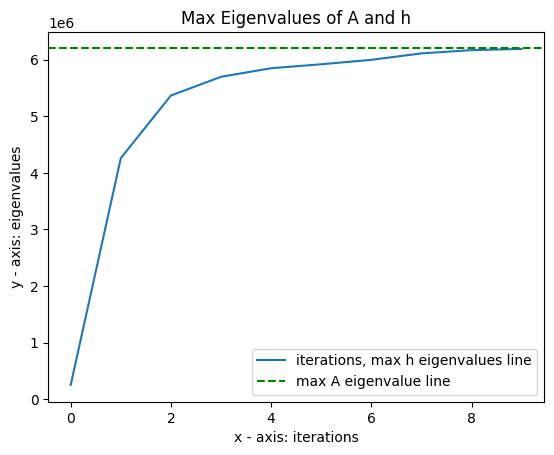

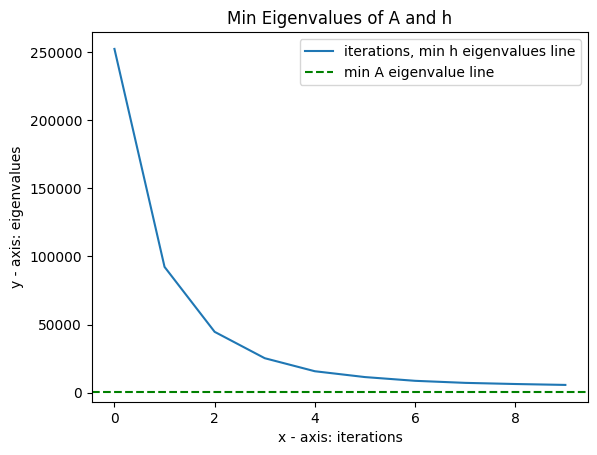

In [ ]:
#Arnoldi
def arnoldi(A, r, m:int):

  h = np.zeros((m+1, m))
  Q = np.zeros((A.shape[0], m+1))

  Eigval_mat= np.zeros((m,2))

  #normalize the input vector
  Q[:,0] =r/np.linalg.norm(r,2)
  print("hello", Q[:,0])

  for j in range(0,m):
      v = A @ Q[:,j]

      for i in range(0,j+1):
          h[i,j] = Q[:,i].T @ v.T #changed v to v.T because v's dimensions were wrong (they were flipped)
          v = v - h[i,j] * Q[:,i]

      h[j+1,j] = np.linalg.norm(v,2)
      Q[:,j+1] = v/h[j+1,j]

      #making h square
      h_square = h[:j+1,:j+1] #on 1st iteration shows 1 row and 1 col since j is 0 then on 2nd iter is 2x2 etc. and keeps h square

      #getting eigenvalues of h_square
      w,v = eigh_tridiagonal(np.diag(h_square), np.diag(h_square, 1))

      Eigval_mat[i,0] = w[-1] #max eigval because last eigval is the largest in w
      Eigval_mat[i,1] = w[0] #min eigval because first eigval is the smallest in w



  #finding eigenvalues of A
  max_w,v=eigsh(A, k=1, which='LM') #max_w and min_w have only 1 eigenvalue because k=1
  min_w,v=eigsh(A, k=1, which='SM')


  #Making Plots

  #making x-values on plots = number of iterations (m)
  x = np.arange(m)

  #making the lines with max eigenvalues of h_square and max eigenvalue of A
  plt.plot(x, Eigval_mat[:,0], label = "iterations, max h eigenvalues line") #x, Eigval_mat[:,0] are the x and y coordinates
  plt.axhline(y = max_w, color ="green", linestyle ="--", label = "max A eigenvalue line") #draws horizontal line at y = max_w

  #x-axis and y-axis labels
  plt.xlabel("x - axis: iterations")
  plt.ylabel("y - axis: eigenvalues")

  #title and function to show the plot
  plt.title("Max Eigenvalues of A and h")
  plt.legend()
  plt.show()

  #making the lines with min eigenvalues of h_square and min eigenvalue of A
  plt.plot(x, Eigval_mat[:,1], label = "iterations, min h eigenvalues line")
  plt.axhline(y = min_w, color ="green", linestyle ="--", label = "min A eigenvalue line")

  #x-axis and y-axis labels
  plt.xlabel("x - axis: iterations")
  plt.ylabel("y - axis: eigenvalues")

  #title and function to show the plot
  plt.title("Min Eigenvalues of A and h")
  plt.legend()
  plt.show()


  return Q, h

#Test matrices: Explained in the "My Comments" section below

A = csr_matrix(mmread(f'{folder}/bcsstk05.mtx')) #csr_matrix turns it into csr format 153x153 Condition Num: 1.428114e+04
#A = csr_matrix(mmread(f'{folder}/bcsstk02.mtx')) #66x66 Condition Num: 4.324971e+03
#A = csr_matrix(mmread(f'{folder}/bcsstk11.mtx')) #error: ARPACK error -1: No convergence (14731 iterations, 0/1 eigenvectors converged)
                                                  #1473x1473 Condition Num: 2.211853e+08
#A = csr_matrix(mmread(f'{folder}/bcsstk11.mtx')) #took too long to execute 15439x15439 Condition Num: 4.413864e+12

print(A.shape[0])
print(A.shape[1])

n = A.shape[0]
m = 10 #much smaller than n

r = np.random.randint(low=0, high=10, size=n) #r: initial vector (length n)

result = arnoldi(A, r, m)

#### Report

Make a few comments about each plot you generated. For Arnoldi, note which eigenvalues get better convergence and how well the algorithm works on different matrices (try with sparse/dense/large/small/etc).

Describe the algorithm and what each step is doing.

###My Comments:
I included a lot of general comments in my code explaining about the plots. As for convergence, my plots seem to converge pretty well. I struggled a lot with convergence but then I got help from Austen and now the plots look pretty good. I think that for bcsstk05, which was the main matrix that I was using, the max eigenvalues converge faster than the min eigenvalues.

When I increased m, then the convegence was better. Otherwise, when I tested the algorithm on bcsstk02 and bcsstk05, both of them seemed to have good convergence. Neither of them seemed to be better than the other. Maybe the min eigenvalues of h for the bcsstk02 converged slightly better than the min eigenvalues of h for bcsstk05. bcsstk02 is a matrix that is 66x66 while bcsstk05 is slightly bigger because it is 153x153. I tried an even bigger matrix which was 1437x1437 called bcsstk11, but that one gave me an error. So, I couldn't compare the convergence. I also tried bcsstk25 which was 15439x15439, but that one took too long to execute, so I couldn't compare that one either. There are not a lot of matrices that the file contains, so I tested the ones that I could.

I included a lot of comments on what my code is doing, but in general, the algorithms gets the eigenvalues of h to approximate the eigenvalues of A. This is shown on the plots. The algorithm also gives an orthogonal matrix Q with m columns and h which is a simple matrix that equals Q.TAQ. If A is symmetric, h is symmetric and has three diagonals that aren't zero whereas everything else is 0. If A is not symmetric, then all of its diagonals below the 1st subdiagonal are 0.